In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Datos_regresion.csv") # read in data downloaded to the local directory
df.head()

,Edad,Diag.Ing1,Diag.Ing2,Diag.Egr1,Diag.Egr2,APACHE,TiempoVAM,Fallece
0,35,1,0,1,0,10,2,0
1,87,2,0,2,0,16,2,0
2,70,4,0,4,0,11,2,0
3,24,13,0,13,5,11,2,0
4,24,3,0,3,0,17,3,0


In [3]:
# Verificamos si hay algún elemento nulo
df.isnull().sum()

Edad         0
Diag.Ing1    0
Diag.Ing2    0
Diag.Egr1    0
Diag.Egr2    0
APACHE       0
TiempoVAM    0
Fallece      0
dtype: int64

In [4]:
df.shape

(208, 8)

In [5]:
df.describe()

,Edad,Diag.Ing1,Diag.Ing2,Diag.Egr1,Diag.Egr2,APACHE,TiempoVAM,Fallece
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,54.192308,11.423077,7.990385,11.418269,10.139423,13.711538,5.865385,0.153846
std,18.983378,9.022454,8.792833,8.935791,8.781556,6.344648,10.697472,0.361672
min,17.000000,1.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000
25%,42.000000,4.000000,0.000000,4.000000,0.000000,9.000000,2.000000,0.000000
50%,56.000000,10.000000,6.000000,9.000000,10.000000,13.000000,3.000000,0.000000
75%,68.000000,14.000000,16.000000,14.000000,16.250000,18.000000,7.000000,0.000000
max,91.000000,40.000000,36.000000,40.000000,36.000000,36.000000,144.000000,1.000000


In [6]:
# Se crea un nuevo dataset con los datos de forma tal que puedan ser procesados por el algoritmo
df_new = df[["Edad", "APACHE", "TiempoVAM"]]
lista = ["Diag.Ing1", "Diag.Ing2", "Diag.Egr1", "Diag.Egr2"]
for i in lista:
    new = pd.get_dummies(df[i], prefix=i)
    df_new = pd.concat([df_new , new], axis = 1)
df_new = pd.concat([df_new , df.Fallece], axis =1)
df = df_new
df.head()

,Edad,APACHE,TiempoVAM,Diag.Ing1_1,Diag.Ing1_2,Diag.Ing1_3,Diag.Ing1_4,Diag.Ing1_5,Diag.Ing1_6,Diag.Ing1_7,...,Diag.Egr2_21,Diag.Egr2_22,Diag.Egr2_23,Diag.Egr2_24,Diag.Egr2_25,Diag.Egr2_27,Diag.Egr2_33,Diag.Egr2_34,Diag.Egr2_36,Fallece
0,35,10,2,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
1,87,16,2,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2,70,11,2,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,0
3,24,11,2,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
4,24,17,3,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0


In [7]:
df.shape

(208, 117)

In [8]:
# Tomamos un dato para predecir su probabilidad de morir
x_pred_f = df.loc[df.Fallece == 1]
x_pred_f = x_pred_f[1:2]
x_pred_f = x_pred_f.drop("Fallece", axis =1)

In [9]:
# Tomamos un dato para predecir su probabilidad de vivir
x_pred_v = df.loc[df.Fallece == 0]
x_pred_v = x_pred_v[:1]
x_pred_v = x_pred_v.drop("Fallece", axis =1)

In [10]:
df['Fallece'].value_counts(sort=True)

Fallece
0    176
1     32
Name: count, dtype: int64

Text(0, 0.5, 'Number of Observations')

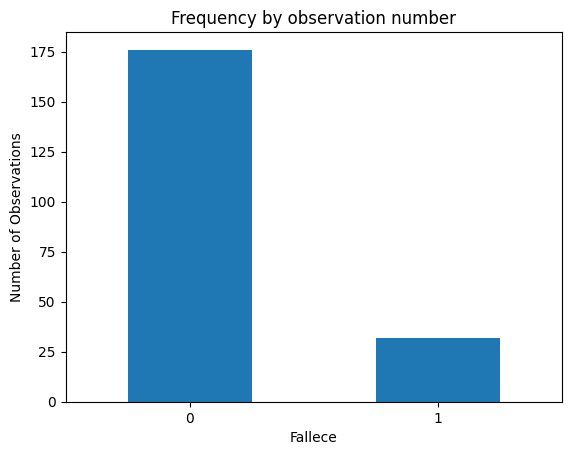

In [11]:
count_classes = df['Fallece'].value_counts(sort=True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Frequency by observation number")
plt.ylabel("Number of Observations")

In [12]:
#definimos nuestras etiquetas y features
y = df['Fallece']
X = df.drop('Fallece', axis=1)